In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Daily_Minimum_Temperatures.csv')
df.head()

,Date,Temp
0,01-01-1981,20.7
1,02-01-1981,17.9
2,03-01-1981,18.8
3,04-01-1981,14.6
4,05-01-1981,15.8


In [4]:
df.tail()

,Date,Temp
2915,26-12-1988,9.5
2916,27-12-1988,12.9
2917,28-12-1988,12.9
2918,29-12-1988,14.8
2919,30-12-1988,14.1


In [ ]:
df.shape

(2920, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2920 non-null   object 
 1   Temp    2920 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.8+ KB


In [5]:
time = pd.date_range(start='1/1/1981',periods=2920,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [ ]:
df.min()

Temp    0.0
dtype: float64

In [6]:
df = df + 1

In [7]:
plt.rcParams['figure.figsize'] = [15,8]

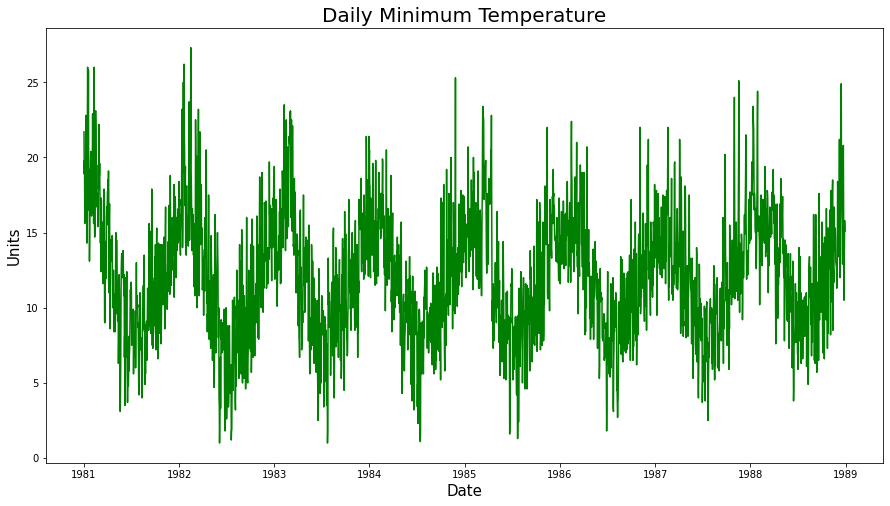

In [8]:
plt.plot(df,color='green')
plt.title('Daily Minimum Temperature',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [9]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [10]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Temp'] = df['Temp'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [11]:
#Split data set into testing dataset and train dataset
train_size = 2625
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2622, 1, 3)
(2622,)
(292, 1, 3)
(292,)


In [14]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 27.6 MB/s 


In [15]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 10 Complete [00h 01m 00s]
val_mape: 14.800355911254883

Best val_mape So Far: 14.800355911254883
Total elapsed time: 00h 12m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 60
first_recurrent_dropout: 0.2
dense_layer: 44
Dropout_rate: 0.30000000000000004
learning_rate: 0.0007130320872076316
Score: 14.800355911254883
Trial summary
Hyperparameters:
rnn_layer: 28
first_recurrent_dropout: 0.1
dense_layer: 84
Dropout_rate: 0.5
learning_rate: 0.0006314363630459197
Score: 14.823513984680176
Trial summary
Hyperparameters:
rnn_layer: 84
first_recurrent_dropout: 0.3
dense_layer: 48
Dropout_rate: 0.1
learning_rate: 0.0008451537528325535
Score: 14.851983070373535
Trial summary
Hyperparameters:
rnn_layer: 28
first_recurrent_dropout: 0.2
dense_layer: 12
Dropout_rate: 0.2
learning_rate: 0.0012526626350960555
Score: 14.934165954589844
Trial summary
Hyperparameters:
rnn_layer: 40
first_recurrent_dropout: 0.3
dense_layer: 20
Dropout_rate: 0.1
learning_rate: 0.0002182433505738606
Score: 14.965188980102539
Trial summary
Hype

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                17520     
                                                                 
 dense (Dense)               (None, 44)                2684      
                                                                 
 dropout (Dropout)           (None, 44)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 45        
                                                                 
Total params: 20,249
Trainable params: 20,249
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [17]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_dim = 3,return_sequences=True,recurrent_dropout=0.3))
model.add(LSTM(32,activation='relu',recurrent_dropout=0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate= 0.0001130320872076316)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 32, epochs = 200)

Epoch 1/200
82/82 [==============================] - 11s 19ms/step - loss: 95.7995 - mape: 95.7995 - val_loss: 91.7367 - val_mape: 91.7367
Epoch 2/200
82/82 [==============================] - 0s 6ms/step - loss: 85.5393 - mape: 85.5393 - val_loss: 78.7912 - val_mape: 78.7912
Epoch 3/200
82/82 [==============================] - 0s 6ms/step - loss: 67.9408 - mape: 67.9408 - val_loss: 56.1534 - val_mape: 56.1534
Epoch 4/200
82/82 [==============================] - 0s 6ms/step - loss: 39.6325 - mape: 39.6325 - val_loss: 23.1660 - val_mape: 23.1660
Epoch 5/200
82/82 [==============================] - 0s 6ms/step - loss: 19.3317 - mape: 19.3317 - val_loss: 16.6429 - val_mape: 16.6429
Epoch 6/200
82/82 [==============================] - 0s 5ms/step - loss: 18.1896 - mape: 18.1896 - val_loss: 16.5911 - val_mape: 16.5911
Epoch 7/200
82/82 [==============================] - 0s 5ms/step - loss: 18.0667 - mape: 18.0667 - val_loss: 16.5683 - val_mape: 16.5683
Epoch 8/200
82/82 [====================

In [18]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [19]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 15.79 
Test MAPE : 15.30 


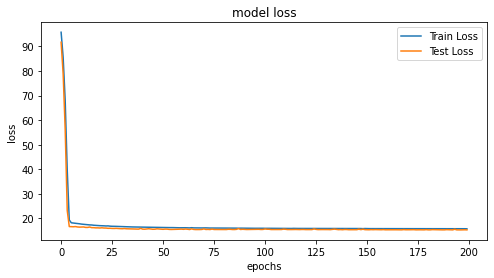

In [20]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [21]:
import seaborn as sns

In [23]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2622,2914)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

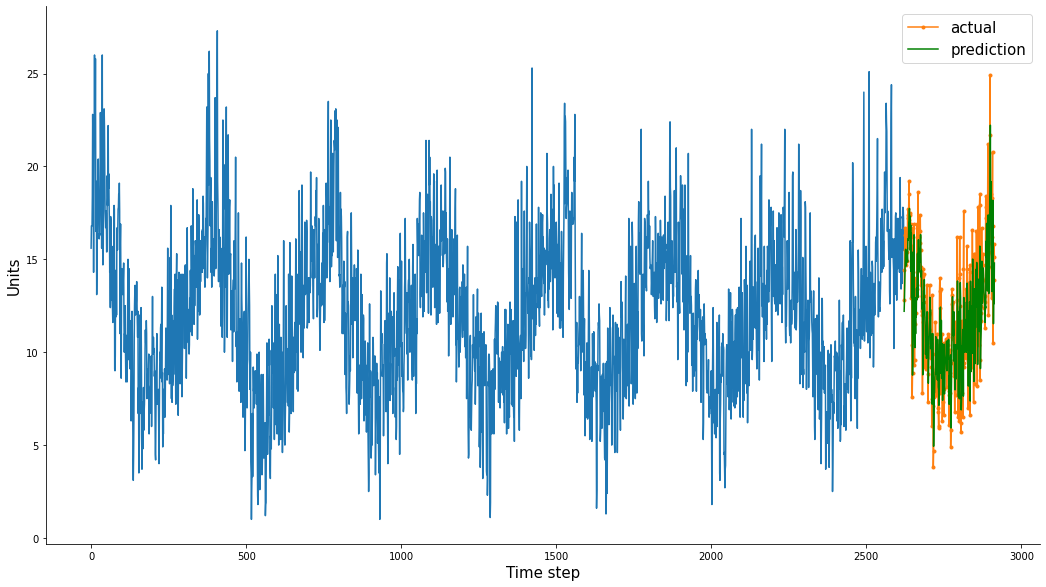

In [24]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)